p=0.000  success=1.0000
p=0.020  success=0.8170
p=0.040  success=0.5102
p=0.060  success=0.2768
p=0.080  success=0.1286
p=0.100  success=0.0526


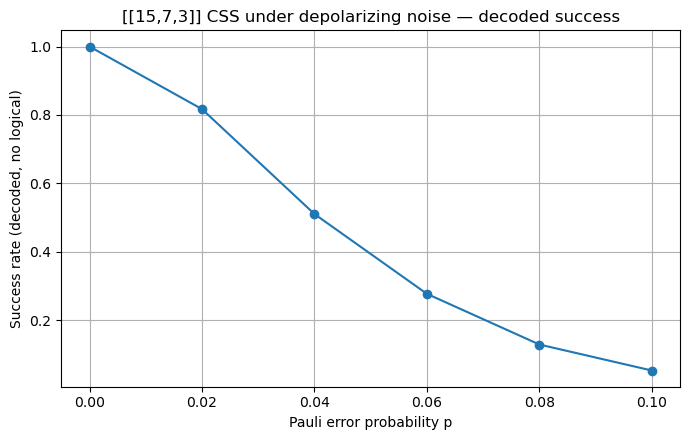

In [14]:
import numpy as np, random, matplotlib.pyplot as plt

# 4×15 self-dual checks from the handout (use for both X- and Z-type)
H = np.array([
    [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
    [0,0,0,1,1,1,1,0,0,0,0,1,1,1,1],
    [0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
    [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1],
], dtype=np.uint8)

rows, n = H.shape

# Build LUT: 4-bit syndrome -> qubit index (and '0000'->None)
LUT = {tuple(H[:,j] % 2): j for j in range(n)}
LUT[(0,0,0,0)] = None

def depolarizing_sample(n, p):
    # P(I)=1-3p, P(X)=P(Y)=P(Z)=p
    eX = np.zeros(n, dtype=np.uint8)
    eZ = np.zeros(n, dtype=np.uint8)
    for q in range(n):
        r = random.random()
        if r < 3*p:
            r2 = random.random()
            if   r2 < 1/3: eX[q] ^= 1         # X
            elif r2 < 2/3: eX[q] ^= 1; eZ[q] ^= 1  # Y = XZ
            else:          eZ[q] ^= 1         # Z
    return eX, eZ

def in_row_span(H, v):
    # Check if v ∈ span_rows(H) over GF(2) by solving H^T a = v
    A = (H.T % 2).astype(int)              # 15×4
    b = (v.reshape(-1,1) % 2).astype(int) # 15×1
    M = np.concatenate([A, b], axis=1)    # 15×5
    nrows, m = M.shape[0], A.shape[1]     # m=4
    r = 0
    for c in range(m):
        pivot = next((i for i in range(r, nrows) if M[i,c]==1), None)
        if pivot is None: continue
        if pivot != r: M[[r,pivot]] = M[[pivot,r]]
        for i in range(nrows):
            if i != r and M[i,c]==1: M[i,:] ^= M[r,:]
        r += 1
    # inconsistent row = [0...0 | 1]
    return not any(np.all(M[i,:m]==0) and M[i,m]==1 for i in range(nrows))

def one_trial(p):
    eX, eZ = depolarizing_sample(n, p)
    sZ = tuple((H @ eX) % 2)     # Z-stab sees X-errors
    sX = tuple((H @ eZ) % 2)     # X-stab sees Z-errors
    jx = LUT[sZ]; jz = LUT[sX]
    if jx is not None: eX[jx] ^= 1
    if jz is not None: eZ[jz] ^= 1
    # success iff residual is a stabilizer (no logical)
    return int(in_row_span(H, eX) and in_row_span(H, eZ))

def sweep(ps, trials=5000, seed=1):
    random.seed(seed)
    rates = []
    for p in ps:
        rate = sum(one_trial(float(p)) for _ in range(trials)) / trials
        print(f"p={p:.3f}  success={rate:.4f}")
        rates.append(rate)
    return rates

PS = np.linspace(0.0, 0.10, 6)
rates = sweep(PS, trials=5000, seed=1)

plt.figure(figsize=(7,4.5))
plt.plot(PS, rates, marker='o')
plt.xlabel("Pauli error probability p")
plt.ylabel("Success rate (decoded, no logical)")
plt.title("[[15,7,3]] CSS under depolarizing noise — decoded success")
plt.grid(True); plt.tight_layout(); plt.show()


p=0.000  success=1.000
p=0.005  success=0.945
p=0.010  success=0.850
p=0.015  success=0.805
p=0.020  success=0.735
p=0.025  success=0.670
p=0.030  success=0.680
p=0.035  success=0.590
p=0.040  success=0.615
p=0.045  success=0.555
p=0.050  success=0.480
p=0.055  success=0.475
p=0.060  success=0.420
p=0.065  success=0.465
p=0.070  success=0.375
p=0.075  success=0.305
p=0.080  success=0.285
p=0.085  success=0.240
p=0.090  success=0.235
p=0.095  success=0.285
p=0.100  success=0.225

Saved plot to: logical_success_vs_p.png


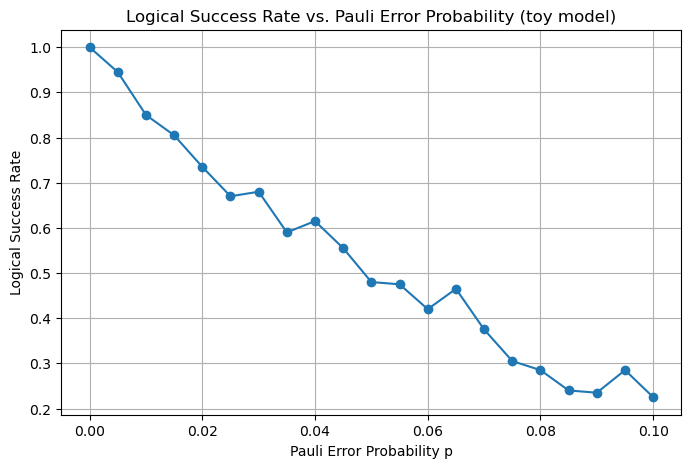

In [16]:
#Example 
import numpy as np
import random
import matplotlib.pyplot as plt

# --- Parity-check matrix (as you had) ---
H = np.array([
    [1,1,1,0,1,1,0,1,1,0,1,0,1,0,1],
    [1,0,1,1,1,0,1,1,0,1,0,1,0,1,0],
    [1,1,0,1,0,1,1,0,1,0,1,1,0,1,0],
    [0,1,1,1,1,1,1,1,0,0,1,1,1,0,0],
    [1,1,0,0,1,1,1,1,1,0,0,1,1,1,0],
    [1,0,1,1,1,1,1,0,1,1,0,0,1,1,1],
    [0,1,1,1,1,1,0,1,1,1,1,0,0,1,1],
    [1,0,1,1,1,0,1,1,1,1,1,1,0,0,1]
], dtype=int)

num_physical = H.shape[1]

def prepare_logical_zero():
    return np.zeros(num_physical, dtype=int)

def apply_pauli_noise(bit_array, p):
    # simple bit-flip proxy: flip each bit with prob p
    out = bit_array.copy()
    for i in range(len(out)):
        if random.random() < p:
            out[i] ^= 1
    return out

def measure_syndromes(bit_array):
    return (H @ bit_array) % 2

def simple_decoder(syndrome):
    # toy rule: if any check is nonzero, flip qubit 0 (silly but visible)
    # (Your earlier code tried to flip the same index as the first nonzero check,
    #  but there are 8 checks vs 15 qubits — that mapping was invalid.)
    if np.any(syndrome):
        corr = np.zeros(num_physical, dtype=int)
        corr[0] = 1
        return corr
    return np.zeros(num_physical, dtype=int)

def apply_correction(bit_array, corrections):
    return (bit_array ^ corrections)

def run_trial(p):
    bits = prepare_logical_zero()
    bits = apply_pauli_noise(bits, p)
    syn  = measure_syndromes(bits)
    corr = simple_decoder(syn)
    bits = apply_correction(bits, corr)
    return int(np.all(bits == 0))

def main():
    random.seed(0)
    np.random.seed(0)

    ps = np.arange(0.0, 0.105, 0.005)
    ntrials = 200

    success_rates = []
    for p in ps:
        succs = sum(run_trial(float(p)) for _ in range(ntrials))
        rate = succs / ntrials
        success_rates.append(rate)
        print(f"p={p:.3f}  success={rate:.3f}")

    # plot AND save (so you still get output in headless environments)
    plt.figure(figsize=(8, 5))
    plt.plot(ps, success_rates, marker='o')
    plt.xlabel('Pauli Error Probability p')
    plt.ylabel('Logical Success Rate')
    plt.title('Logical Success Rate vs. Pauli Error Probability (toy model)')
    plt.grid(True)
    outfile = "logical_success_vs_p.png"
    plt.savefig(outfile, dpi=150, bbox_inches='tight')
    print(f"\nSaved plot to: {outfile}")

    # show if an interactive backend is available
    try:
        plt.show()
    except Exception as e:
        print(f"(Plot display skipped: {e})")

if __name__ == "__main__":
    main()
